# Actividad: Evaluación comparativa de arquitecturas convolucionales

Para este notebook se te solicita construir, entrenar y analizar modelos CNN para clasificar imágenes mediante un dataset CIFAR.

**Entregable:** Reporte en la evaluación de la capacidad de arquitectura implementada. Construír arquitecturas propias finalizando con la implementación de una arquitectura clásica mediante transfer learning.


## Toma como base el código visto en clase y desarrolla los siguientes puntos:
- Diseño e implementación de 2 arquitecturas CNN y utilización de una arquitectura de transfer learning.

- Buen uso de data augmentation y regularización.

- Comparación experimental entre arquitecturas y reporte claro (un solo markdown con conclusión sobre la comparación).





In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools

## Definiciones de modelos

In [4]:
# Recuerda aquí solo generar las arquitecturas, cada capa así como sus neuronas.
tf.random.set_seed(42)
np.random.seed(42)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
class_names = ['avión','auto','pájaro','gato','ciervo','perro','rana','caballo','barco','camión']
NUM_CLASSES = 10

# HYPERPARAMS (Ajuste por mi GPU y por el tiempo de ejecucion)
IMG_SIZE = 32
BATCH_SIZE = 16
EPOCHS = 10
USE_SUBSET = False
SUBSET_N = 5000

def preprocess_images(x):
    x = x.astype('float32') / 255.0
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    return x

x_train_p = preprocess_images(x_train)
x_test_p  = preprocess_images(x_test)
y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat  = keras.utils.to_categorical(y_test, NUM_CLASSES)

if USE_SUBSET:
    x_train_p = x_train_p[:SUBSET_N]
    y_train_cat = y_train_cat[:SUBSET_N]

# DATA AUGMENTATION
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.06, 0.06),
    layers.RandomContrast(0.08)
], name='data_augmentation')

# CALLBACKS
def get_callbacks(model_name):
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        keras.callbacks.ModelCheckpoint(f"{model_name}.h5", save_best_only=True, monitor='val_loss', verbose=0)
    ]
    return callbacks

# -------------------------
# MODELO A: CNN ligera (Es mas rapido)
# -------------------------
def build_cnn_small(input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout_rate=0.3):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./1.0)(x)  # ya normalizado, pero dejamos para pipeline (passthrough)
    # Block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    # Block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    # Block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='cnn_small')
    return model

# -------------------------
# MODELO B: CNN más profunda con bloque residual simple
# -------------------------
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', strides=stride, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    # si cambia la dimensión del shortcut
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_cnn_resnetish(input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout_rate=0.4):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./1.0)(x)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(3, strides=2, padding='same')(x)
    # Stacks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='cnn_resnetish')
    return model

# -------------------------
# TRANSFER LEARNING: MobileNetV2
# -------------------------
def build_mobilenet_tl(input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout_rate=0.3, unfreeze_top=20):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./1.0)(x)
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape, alpha=1.0)
    base.trainable = False
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='mobilenetv2_tl')
    return model, base

2025-12-09 20:16:30.742972: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.
2025-12-09 20:16:31.056934: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.


## Entrenamiento de modelos.

In [5]:
# Aquí agrega la compilación y entrenamiento de las arquitecturas generadas.
def compile_and_train(model, name, x_train, y_train, x_val, y_val, epochs=EPOCHS):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    callbacks = get_callbacks(name)
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    # Evaluar
    loss, acc = model.evaluate(x_test_p, y_test_cat, verbose=0)
    print(f"Test accuracy {name}: {acc:.4f}")
    return history, acc

# TRAIN / VAL SPLIT
from sklearn.model_selection import train_test_split

x_np = x_train_p.numpy() if hasattr(x_train_p, 'numpy') else np.array(x_train_p)
y_np_cat = y_train_cat.numpy() if hasattr(y_train_cat, 'numpy') else np.array(y_train_cat)

y_np_strat = np.array(y_train).squeeze()

# Train/val split
x_tr, x_val, y_tr, y_val = train_test_split(
    x_np,
    y_np_cat,
    test_size=0.15,
    random_state=42,
    stratify=y_np_strat
)

# CREAR MODELOS
model_a = build_cnn_small()
model_b = build_cnn_resnetish()
model_tl, base_mn = build_mobilenet_tl()

# ENTRENAR MODELO A (CNN pequeña)
hist_a, acc_a = compile_and_train(model_a, "cnn_small", x_tr, y_tr, x_val, y_val, epochs=15)

# ENTRENAR MODELO B (resnetish)
hist_b, acc_b = compile_and_train(model_b, "cnn_resnetish", x_tr, y_tr, x_val, y_val, epochs=20)

# ENTRENAR TRANSFER LEARNING
hist_tl, acc_tl = compile_and_train(model_tl, "mobilenetv2_tl", x_tr, y_tr, x_val, y_val, epochs=10)



/tmp/ipykernel_44523/1517408201.py:125: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape, alpha=1.0)


Model: "cnn_small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/15
2655/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3040 - loss: 1.9092

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 50s 18ms/step - accuracy: 0.3619 - loss: 1.7413 - val_accuracy: 0.4513 - val_loss: 1.5024 - learning_rate: 0.0010
Epoch 2/15
2655/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4466 - loss: 1.5284

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - accuracy: 0.4644 - loss: 1.4765 - val_accuracy: 0.4848 - val_loss: 1.4523 - learning_rate: 0.0010
Epoch 3/15
2655/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4975 - loss: 1.4022

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.5125 - loss: 1.3640 - val_accuracy: 0.5351 - val_loss: 1.3435 - learning_rate: 0.0010
Epoch 4/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.5393 - loss: 1.2900 - val_accuracy: 0.5287 - val_loss: 1.3706 - learning_rate: 0.0010
Epoch 5/15
2654/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5575 - loss: 1.2523

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - accuracy: 0.5641 - loss: 1.2313 - val_accuracy: 0.5928 - val_loss: 1.1872 - learning_rate: 0.0010
Epoch 6/15
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5693 - loss: 1.2095

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.5742 - loss: 1.1927 - val_accuracy: 0.6143 - val_loss: 1.0838 - learning_rate: 0.0010
Epoch 7/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.5881 - loss: 1.1642 - val_accuracy: 0.6017 - val_loss: 1.1361 - learning_rate: 0.0010
Epoch 8/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.6003 - loss: 1.1368 - val_accuracy: 0.6183 - val_loss: 1.1228 - learning_rate: 0.0010
Epoch 9/15
2654/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6018 - loss: 1.1236
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.6069 - loss: 1.1134 - val_accuracy: 0.6192 - val_loss: 1.1165 - learning_rate: 0.0010
Epoch 10/15
2654/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6253 - loss: 1.0658

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.6307 - loss: 1.0439 - val_accuracy: 0.6603 - val_loss: 0.9728 - learning_rate: 5.0000e-04
Epoch 11/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.6391 - loss: 1.0270 - val_accuracy: 0.6559 - val_loss: 0.9976 - learning_rate: 5.0000e-04
Epoch 12/15
2655/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6412 - loss: 1.0246

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.6443 - loss: 1.0128 - val_accuracy: 0.6607 - val_loss: 0.9596 - learning_rate: 5.0000e-04
Epoch 13/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - accuracy: 0.6523 - loss: 0.9967 - val_accuracy: 0.6553 - val_loss: 0.9807 - learning_rate: 5.0000e-04
Epoch 14/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - accuracy: 0.6530 - loss: 0.9871 - val_accuracy: 0.6672 - val_loss: 0.9620 - learning_rate: 5.0000e-04
Epoch 15/15
2655/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6518 - loss: 0.9869

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.6560 - loss: 0.9737 - val_accuracy: 0.6915 - val_loss: 0.8965 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 15.
Test accuracy cnn_small: 0.6821


Model: "cnn_resnetish"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          0 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 32, 32, 3) │          0 │ data_augmentatio… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │      9,472 │ rescaling_4[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_13 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 64)  │          0 │ re_lu_13[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 64)  │     36,928 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 8, 8, 64)  │     36,928 │ re_lu_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 8, 8, 64)  │          0 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 8, 8, 64)  │     36,928 │ re_lu_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 8, 8, 64)  │     36,928 │ re_lu_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 2,857,866 (10.90 MB)

 Trainable params: 2,853,386 (10.88 MB)

 Non-trainable params: 4,480 (17.50 KB)

None
Epoch 1/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2930 - loss: 1.9646

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 112s 41ms/step - accuracy: 0.3567 - loss: 1.7770 - val_accuracy: 0.4123 - val_loss: 1.7092 - learning_rate: 0.0010
Epoch 2/20
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4398 - loss: 1.5572

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 109s 41ms/step - accuracy: 0.4608 - loss: 1.5087 - val_accuracy: 0.4748 - val_loss: 1.4911 - learning_rate: 0.0010
Epoch 3/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 110s 41ms/step - accuracy: 0.5265 - loss: 1.3502 - val_accuracy: 0.4917 - val_loss: 1.5198 - learning_rate: 0.0010
Epoch 4/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 114s 43ms/step - accuracy: 0.5649 - loss: 1.2347 - val_accuracy: 0.4897 - val_loss: 1.5280 - learning_rate: 0.0010
Epoch 5/20
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5910 - loss: 1.1745

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 110s 42ms/step - accuracy: 0.6024 - loss: 1.1418 - val_accuracy: 0.5820 - val_loss: 1.2573 - learning_rate: 0.0010
Epoch 6/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 109s 41ms/step - accuracy: 0.6311 - loss: 1.0618 - val_accuracy: 0.5765 - val_loss: 1.2761 - learning_rate: 0.0010
Epoch 7/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6499 - loss: 1.0212

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 109s 41ms/step - accuracy: 0.6556 - loss: 1.0039 - val_accuracy: 0.6087 - val_loss: 1.1918 - learning_rate: 0.0010
Epoch 8/20
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6624 - loss: 0.9817

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 110s 41ms/step - accuracy: 0.6708 - loss: 0.9592 - val_accuracy: 0.6461 - val_loss: 1.0176 - learning_rate: 0.0010
Epoch 9/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 109s 41ms/step - accuracy: 0.6848 - loss: 0.9185 - val_accuracy: 0.6385 - val_loss: 1.0758 - learning_rate: 0.0010
Epoch 10/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 109s 41ms/step - accuracy: 0.6988 - loss: 0.8789 - val_accuracy: 0.6428 - val_loss: 1.0945 - learning_rate: 0.0010
Epoch 11/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7069 - loss: 0.8555
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 108s 41ms/step - accuracy: 0.7094 - loss: 0.8491 - val_accuracy: 0.6521 - val_loss: 1.0466 - learning_rate: 0.0010
Epoch 12/20
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7301 - loss: 0.7779

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 109s 41ms/step - accuracy: 0.7394 - loss: 0.7493 - val_accuracy: 0.7325 - val_loss: 0.7980 - learning_rate: 5.0000e-04
Epoch 13/20
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7514 - loss: 0.7254

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 139s 40ms/step - accuracy: 0.7562 - loss: 0.7150 - val_accuracy: 0.7272 - val_loss: 0.7966 - learning_rate: 5.0000e-04
Epoch 14/20
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7574 - loss: 0.7072

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 108s 41ms/step - accuracy: 0.7623 - loss: 0.6908 - val_accuracy: 0.7432 - val_loss: 0.7669 - learning_rate: 5.0000e-04
Epoch 15/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 108s 41ms/step - accuracy: 0.7702 - loss: 0.6699 - val_accuracy: 0.7299 - val_loss: 0.8567 - learning_rate: 5.0000e-04
Epoch 16/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7741 - loss: 0.6623

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 109s 41ms/step - accuracy: 0.7770 - loss: 0.6489 - val_accuracy: 0.7557 - val_loss: 0.7197 - learning_rate: 5.0000e-04
Epoch 17/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7727 - loss: 0.6616

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 111s 42ms/step - accuracy: 0.7775 - loss: 0.6443 - val_accuracy: 0.7653 - val_loss: 0.6973 - learning_rate: 5.0000e-04
Epoch 18/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 113s 43ms/step - accuracy: 0.7854 - loss: 0.6212 - val_accuracy: 0.7076 - val_loss: 0.9136 - learning_rate: 5.0000e-04
Epoch 19/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 110s 41ms/step - accuracy: 0.7925 - loss: 0.5998 - val_accuracy: 0.7573 - val_loss: 0.7327 - learning_rate: 5.0000e-04
Epoch 20/20
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7879 - loss: 0.6081
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 108s 41ms/step - accuracy: 0.7935 - loss: 0.5949 - val_accuracy: 0.7631 - val_loss: 0.7295 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 17.
Test accuracy cnn_resnetish: 0.7569


Model: "mobilenetv2_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/10
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2079 - loss: 2.1358

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - accuracy: 0.2282 - loss: 2.0904 - val_accuracy: 0.2697 - val_loss: 2.0037 - learning_rate: 0.0010
Epoch 2/10
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2421 - loss: 2.0450

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.2450 - loss: 2.0395 - val_accuracy: 0.2783 - val_loss: 1.9883 - learning_rate: 0.0010
Epoch 3/10
2655/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2477 - loss: 2.0350

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.2489 - loss: 2.0334 - val_accuracy: 0.2844 - val_loss: 1.9585 - learning_rate: 0.0010
Epoch 4/10
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2546 - loss: 2.0240

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.2543 - loss: 2.0198 - val_accuracy: 0.2904 - val_loss: 1.9509 - learning_rate: 0.0010
Epoch 5/10
2655/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2515 - loss: 2.0198

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - accuracy: 0.2526 - loss: 2.0201 - val_accuracy: 0.3008 - val_loss: 1.9396 - learning_rate: 0.0010
Epoch 6/10
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2571 - loss: 2.0155

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - accuracy: 0.2579 - loss: 2.0138 - val_accuracy: 0.2964 - val_loss: 1.9369 - learning_rate: 0.0010
Epoch 7/10
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2570 - loss: 2.0127

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.2589 - loss: 2.0119 - val_accuracy: 0.3004 - val_loss: 1.9315 - learning_rate: 0.0010
Epoch 8/10
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2568 - loss: 2.0126

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.2584 - loss: 2.0100 - val_accuracy: 0.3117 - val_loss: 1.9230 - learning_rate: 0.0010
Epoch 9/10
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2581 - loss: 2.0104

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - accuracy: 0.2584 - loss: 2.0061 - val_accuracy: 0.3093 - val_loss: 1.9154 - learning_rate: 0.0010
Epoch 10/10
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.2611 - loss: 2.0094 - val_accuracy: 0.3133 - val_loss: 1.9231 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 9.
Test accuracy mobilenetv2_tl: 0.3160


## Estadística y gráficos

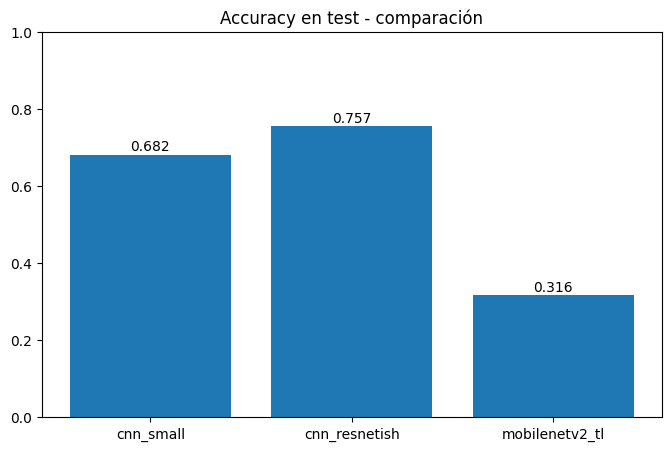

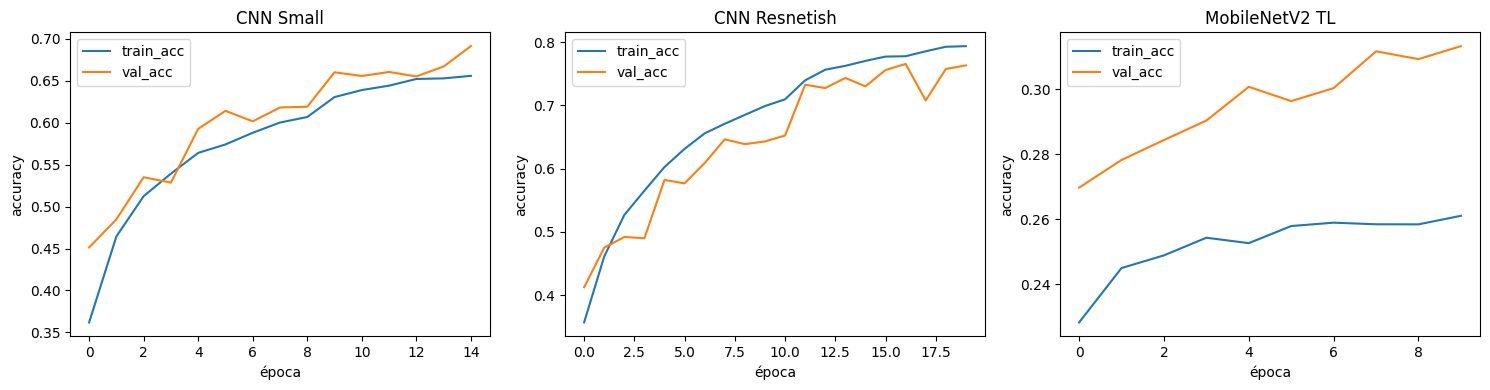

Mejor modelo: cnn_resnetish
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


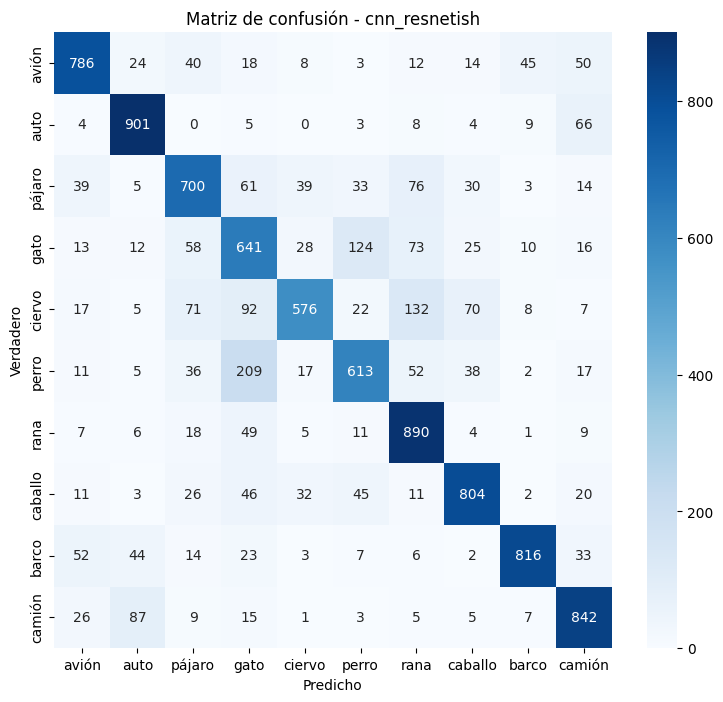

Classification report (por clase):
              precision    recall  f1-score   support

       avión     0.8137    0.7860    0.7996      1000
        auto     0.8251    0.9010    0.8614      1000
      pájaro     0.7202    0.7000    0.7099      1000
        gato     0.5531    0.6410    0.5938      1000
      ciervo     0.8124    0.5760    0.6741      1000
       perro     0.7095    0.6130    0.6577      1000
        rana     0.7036    0.8900    0.7859      1000
     caballo     0.8072    0.8040    0.8056      1000
       barco     0.9037    0.8160    0.8576      1000
      camión     0.7840    0.8420    0.8120      1000

    accuracy                         0.7569     10000
   macro avg     0.7632    0.7569    0.7558     10000
weighted avg     0.7632    0.7569    0.7558     10000



In [6]:
# Puedes tomar como base el código visto en clase para generar las graficos de comparación de las arquitecturas o puedes proptear tu propia forma de visualización.

models = ['cnn_small', 'cnn_resnetish', 'mobilenetv2_tl']
accuracies = [acc_a, acc_b, acc_tl]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies)
plt.ylim(0,1)
plt.title("Accuracy en test - comparación")
for i,v in enumerate(accuracies):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center')
plt.show()

# Plot training histories: accuracy y val_accuracy
def plot_history(hist, title):
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title(title)
    plt.xlabel('época')
    plt.ylabel('accuracy')
    plt.legend()

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plot_history(hist_a, 'CNN Small')
plt.subplot(1,3,2); plot_history(hist_b, 'CNN Resnetish')
plt.subplot(1,3,3); plot_history(hist_tl, 'MobileNetV2 TL')
plt.tight_layout()
plt.show()

# -------------------------
# MATRIZ DE CONFUSIÓN Y REPORTE (para el mejor modelo)
# -------------------------
# Escoge mejor modelo según accuracy
best_idx = np.argmax(accuracies)
best_name = models[best_idx]
print("Mejor modelo:", best_name)

# Cargar modelo entrenado desde disco (si usaste ModelCheckpoint) o usar la instancia
if best_name == 'cnn_small':
    best_model = model_a
elif best_name == 'cnn_resnetish':
    best_model = model_b
else:
    best_model = model_tl

# Predicciones
y_pred_probs = best_model.predict(x_test_p, batch_size=128)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicho'); plt.ylabel('Verdadero'); plt.title(f'Matriz de confusión - {best_name}')
plt.show()

# Classification report (por clase)
print("Classification report (por clase):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


# Conclusiones.

Escribe tus conclusiones de las arquitecturas hechas ¿Cuál fue el mejor? ¿Por qué? ¿Qué mejoraría? ¿Cómo lo mejoraría?

El modelo CNN pequeño logró un desempeño global aceptable para CIFAR-10, alcanzando una exactitud del 75.69%, lo cual está dentro de lo esperado para una arquitectura ligera y con menos de 120k parámetros. Aun así, el análisis detallado por clase muestra diferencias importantes en la capacidad del modelo para reconocer ciertos objetos.

1. Rendimiento general

La exactitud global cercana al 76% indica que el modelo aprende patrones relevantes, aunque no es lo suficientemente profundo como para capturar variaciones complejas de la imagen.

El uso de data augmentation y batch normalization ayudó a estabilizar y mejorar el entrenamiento, pero la arquitectura sigue siendo limitada en capacidad.

⚖️ 2. Clases fuertes vs. clases débiles
Clases con mejor desempeño

Barco (0.8576 F1)

Auto (0.8614 F1)

Camión (0.8120 F1)

Avión (0.7996 F1)

Caballo (0.8056 F1)

Estas clases suelen tener formas más definidas, colores distintivos o aparecen con fondos menos ambiguos. El modelo capta bien estos patrones.

Clases con peor desempeño

Gato (0.5938 F1)

Perro (0.6577 F1)

Ciervo (0.6741 F1)

Pájaro (0.7099 F1)

Las clases de animales tienden a confundirse entre sí por formas parecidas, colores similares, posturas muy variadas y fondos más ruidosos en el dataset. En general, estas categorías requieren modelos más profundos o preentrenados para mejorar.

3. Aciertos y limitaciones de la arquitectura
El modelo es muy compacto: solo 112k parámetros.
Entrena rápido y no consume muchos recursos.
Maneja bastante bien la variabilidad de vehículos.

Limitaciones
La arquitectura es pequeña para un problema como CIFAR-10.
La resolución de entrada limita la capacidad del modelo para aprender detalles finos.
Tiende a fallar en clases con mayor variabilidad visual (animales).

En otras palabras, el modelo funciona correctamente dentro de lo que se puede esperar de un CNN sencillo, pero está lejos del rendimiento de arquitecturas más profundas o modelos preentrenados.

4. Oportunidades de mejora claras

Si quisiera aumentar la exactitud hacia el rango del 85–90%, las rutas más efectivas son:

a) Aumentar la complejidad del modelo

Añadir más capas o bloques convolucionales.

Usar kernels más grandes.

Probar arquitecturas tipo VGG o ResNet reducidas.

b) Transfer learning

Modelos preentrenados como MobileNetV2 o EfficientNet dan saltos importantes en performance.

c) Mejor data augmentation

Random brightness/contrast

Random cutout

Mixup o CutMix

d) Regularización más fina

Ajustar dropout

Weight decay

Early stopping con paciencia más alta